In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input
import matplotlib.pyplot as plt
from IPython.display import HTML

In [21]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [22]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 606 files belonging to 2 classes.


In [23]:
class_names = dataset.class_names
class_names

['healthy', 'parkinson']

In [24]:
n_classes = len(class_names)

In [25]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1]


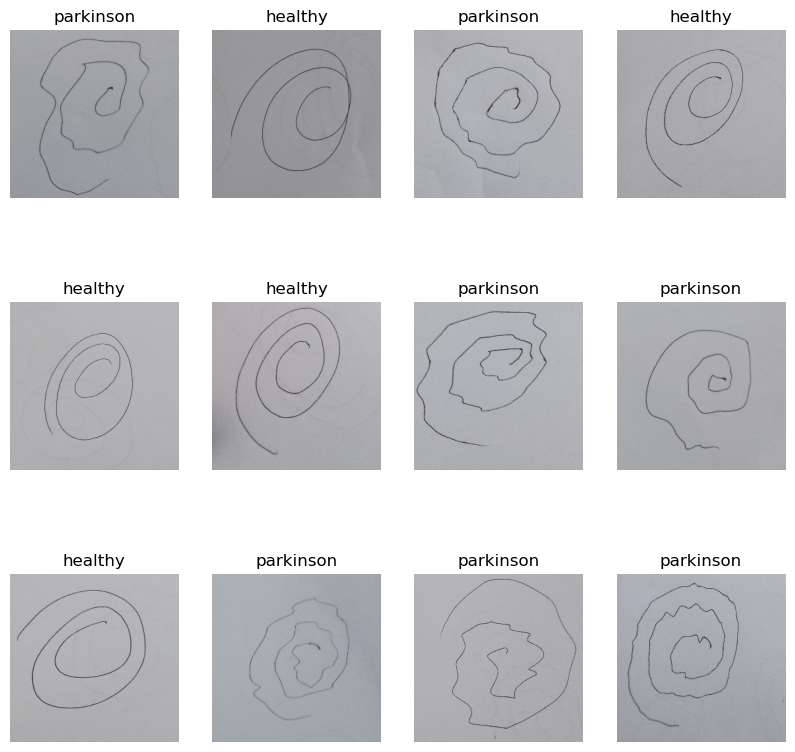

In [26]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [27]:
len(dataset)

19

In [28]:
train_size = 0.8
len(dataset)*train_size

15.200000000000001

In [29]:
train_ds = dataset.take(15)
len(train_ds)

15

In [30]:
test_ds = dataset.skip(15)
len(test_ds)

4

In [31]:
val_size=0.1
len(dataset)*val_size

1.9000000000000001

In [32]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [33]:
test_ds = test_ds.skip(2)
len(test_ds)

2

In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [36]:
len(train_ds)

15

In [37]:
len(val_ds)

1

In [38]:
len(test_ds)

3

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255),
])

In [41]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [42]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
from tensorflow.keras import layers, models

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    layers.Input(shape=input_shape),  # Define the input shape
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,682 (717.51 KB)

 Trainable params: 183,682 (717.51 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5139 - loss: 0.6970 - val_accuracy: 0.6875 - val_loss: 0.6930
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5348 - loss: 0.6931 - val_accuracy: 0.6562 - val_loss: 0.6886
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5350 - loss: 0.6925 - val_accuracy: 0.6562 - val_loss: 0.6892
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5197 - loss: 0.6928 - val_accuracy: 0.6562 - val_loss: 0.6881
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4979 - loss: 0.6934 - val_accuracy: 0.6562 - val_loss: 0.6876
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5536 - loss: 0.6915 - val_accuracy: 0.6562 - val_loss: 0.6858
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4683 - loss: 0.6951 - val_accuracy: 0.6562 - val_loss: 0.6875
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5164 - loss: 0.6927 - val_accuracy: 0.6562 - v

In [46]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 750ms/step - accuracy: 1.0000 - loss: 2.2004e-04


In [47]:
scores

[0.00025828578509390354, 1.0]

In [48]:
history

In [49]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 15}

In [50]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [51]:
type(history.history['loss'])

list

In [52]:
len(history.history['loss'])

100

In [53]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6968109011650085,
 0.693311333656311,
 0.6932172179222107,
 0.6929448246955872,
 0.6928340792655945]

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

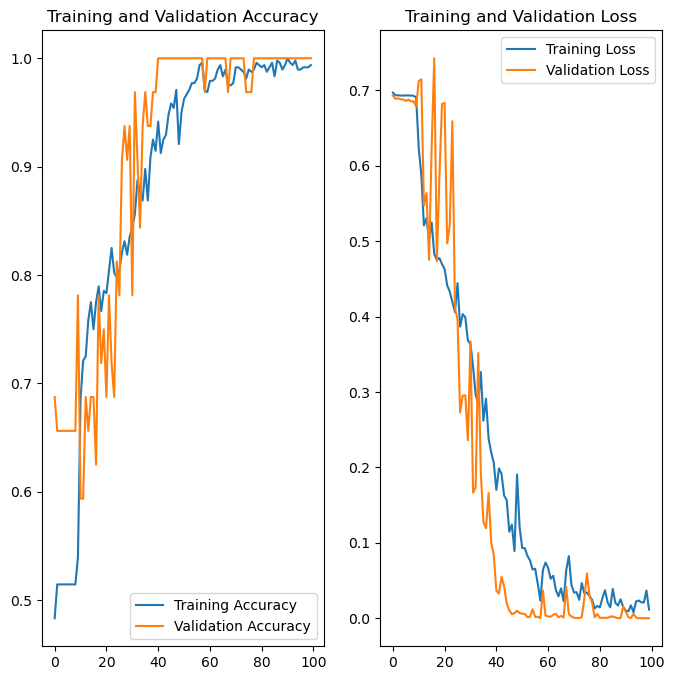

In [55]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: parkinson
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: parkinson


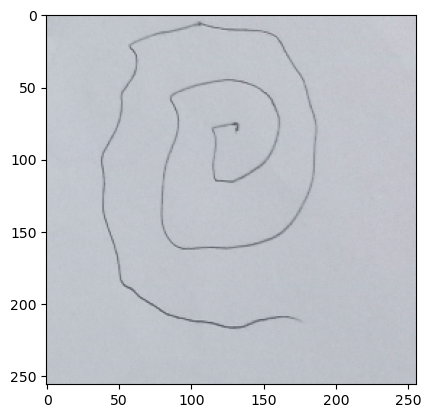

In [56]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [45]:
import os

# Determine the next model version number
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1

# Save the model with the .keras extension
model.save(f"../models/{model_version}.keras")